In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
import pywt.data
from helpers import mle_gamma

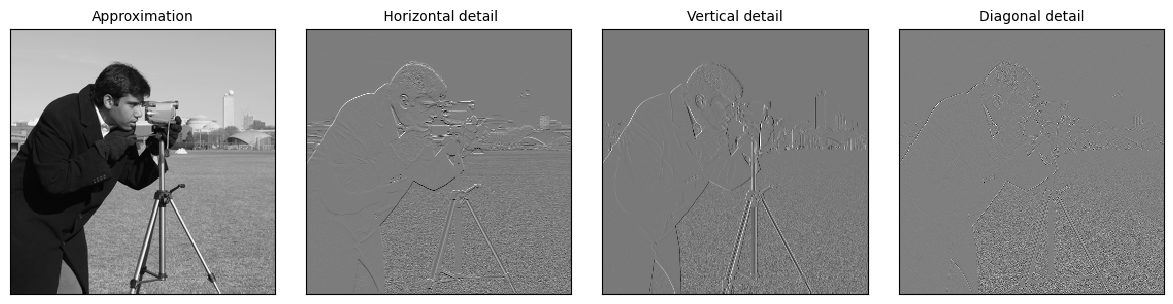

In [2]:
# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
axes[1][1].axes

In [18]:
LL_true.shape

(162, 246)

In [19]:
LH_true.shape

(162, 246)

In [54]:
# before adding noise
coeffs2 = pywt.dwt2(original, 'haar')
LL_true, (LH_true, HL_true, HH_true) = coeffs2

In [57]:
upper = np.concatenate([LL_true, HL_true], axis=1)
lower = np.concatenate([LH_true, HH_true], axis=1)
im = np.concatenate([upper, lower], axis=0)
# im = np.concatenate([X, im[0:323, :]], axis=1)
cv2.imwrite("original_transform.png", im)

True

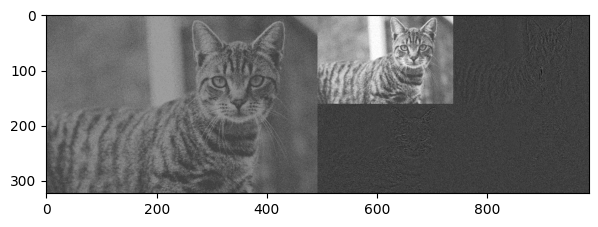

In [50]:
figure = plt.figure(figsize=(7,5))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

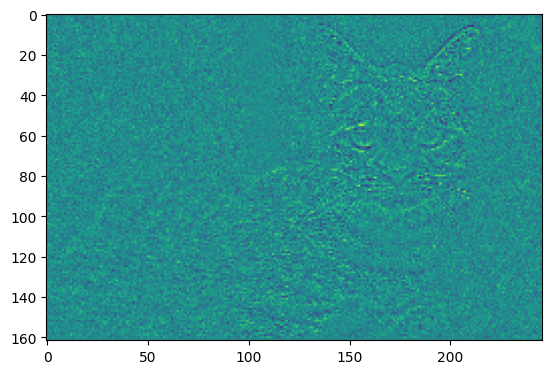

In [41]:
plt.imshow(LH_true)

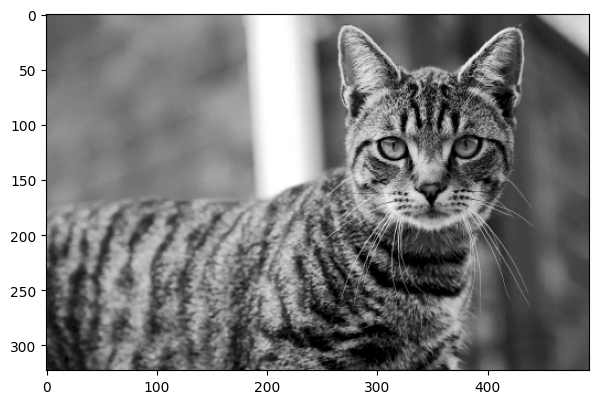

7.175900833082405 7.862817424470541 3.552569507176554


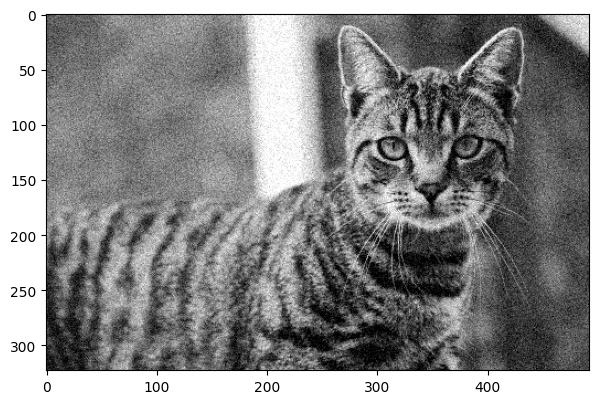

In [42]:
original = cv2.imread("cat.png", cv2.IMREAD_GRAYSCALE )
original = cv2.resize(original, (0, 0), fx = 0.5, fy = 0.5)
figure = plt.figure(figsize=(7,5))
plt.imshow(original, cmap=plt.cm.gray)
plt.show()

# before adding noise
coeffs2 = pywt.dwt2(original, 'haar')
LL_true, (LH_true, HL_true, HH_true) = coeffs2

gamma_LH = mle_gamma(LH_true.ravel())
gamma_HL = mle_gamma(HL_true.ravel())
gamma_HH = mle_gamma(HH_true.ravel())

print(gamma_LH, gamma_HL, gamma_HH)

# add noise
s = original.shape
sigma = 20
X = original + np.random.normal(scale=sigma, size=s)
X = np.clip(X, 0, 255)

figure = plt.figure(figsize=(7,5))
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

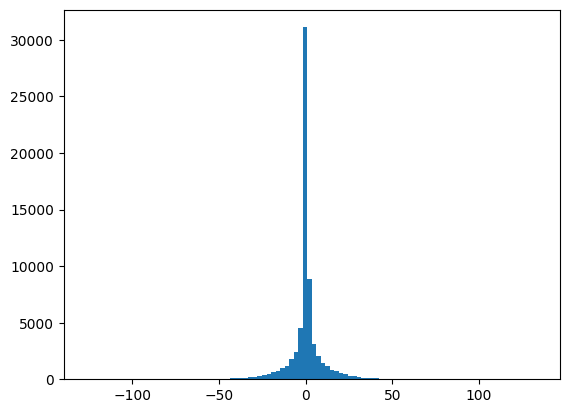

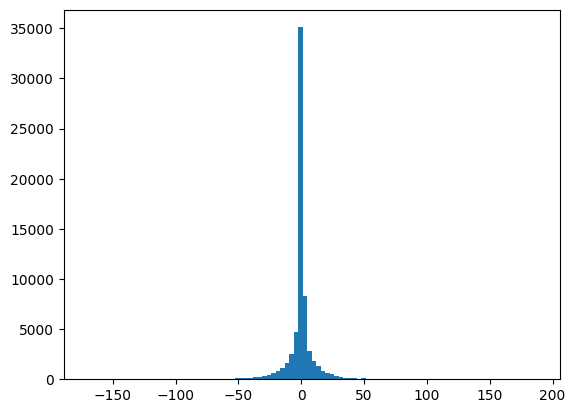

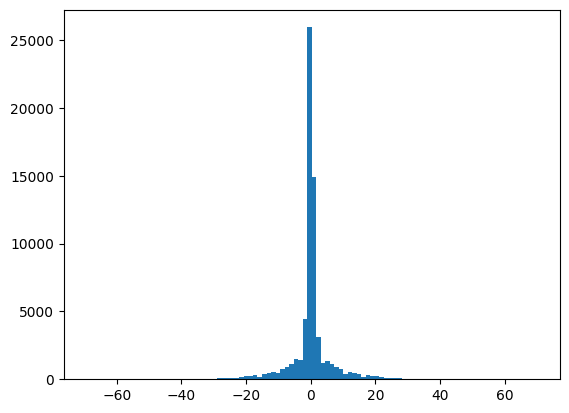

In [58]:
plt.hist(LH.ravel(), bins=100)
plt.show()
plt.hist(HL.ravel(), bins=100)
plt.show()
plt.hist(HH.ravel(), bins=100)
plt.show()

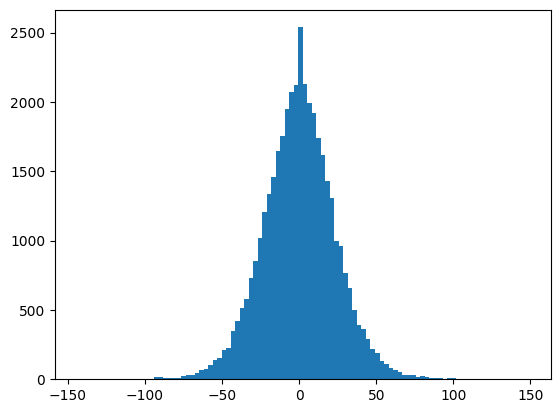

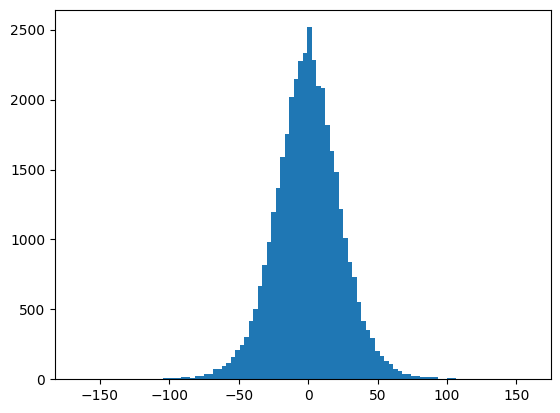

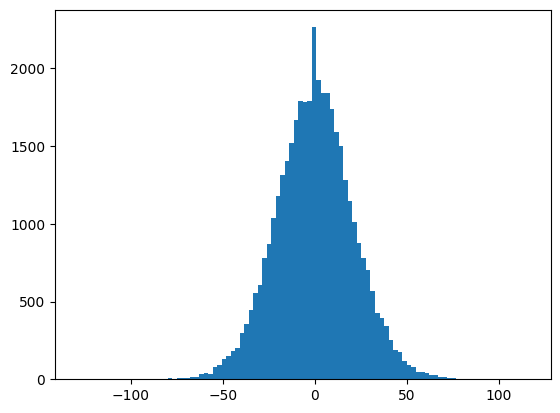

In [59]:
coeffs2 = pywt.dwt2(X, 'haar')
LL, (LH, HL, HH) = coeffs2

plt.hist(LH.ravel(), bins=100)
plt.show()
plt.hist(HL.ravel(), bins=100)
plt.show()
plt.hist(HH.ravel(), bins=100)
plt.show()

In [62]:
from hyperparameters_estimations import gradient_descent_line_search, ml_objective_gamma_sigma
from helpers import map_estimate, mmse_estimate, mse
import tqdm

In [63]:
LH_map = map_estimate(LH, sigma=sigma, gamma=gamma_LH)
LH_mmse = mmse_estimate(LH, sigma=sigma, gamma=gamma_LH)
print("MSE LH ML-MAP-MMSE", np.mean(np.square(LH-LH_true)), np.mean(np.square(LH_map-LH_true)), np.mean(np.square(LH_mmse-LH_true)))

HL_map = map_estimate(HL, sigma=sigma, gamma=gamma_HL)
HL_mmse = mmse_estimate(HL, sigma=sigma, gamma=gamma_HL)
print("MSE HL ML-MAP-MMSE", np.mean(np.square(HL-LH_true)), np.mean(np.square(HL_map-LH_true)), np.mean(np.square(HL_mmse-LH_true)))

HH_map = map_estimate(HH, sigma=sigma, gamma=gamma_HH)
HH_mmse = mmse_estimate(HH, sigma=sigma, gamma=gamma_HH)
print("MSE HH ML-MAP-MMSE", np.mean(np.square(HH-LH_true)), np.mean(np.square(HH_map-LH_true)), np.mean(np.square(HH_mmse-LH_true)))

MSE LH ML-MAP-MMSE 377.97900910353167 158.03977558604367 122.08584164786298
MSE HL ML-MAP-MMSE 755.6458459475839 199.42766486593575 224.00774540387195
MSE HH ML-MAP-MMSE 621.8601684676448 183.69900100770894 185.03501992888602


In [65]:
cv2.imwrite("map_recon.png", inv_map)
cv2.imwrite("mmse_recon.png", inv_mmse)

True

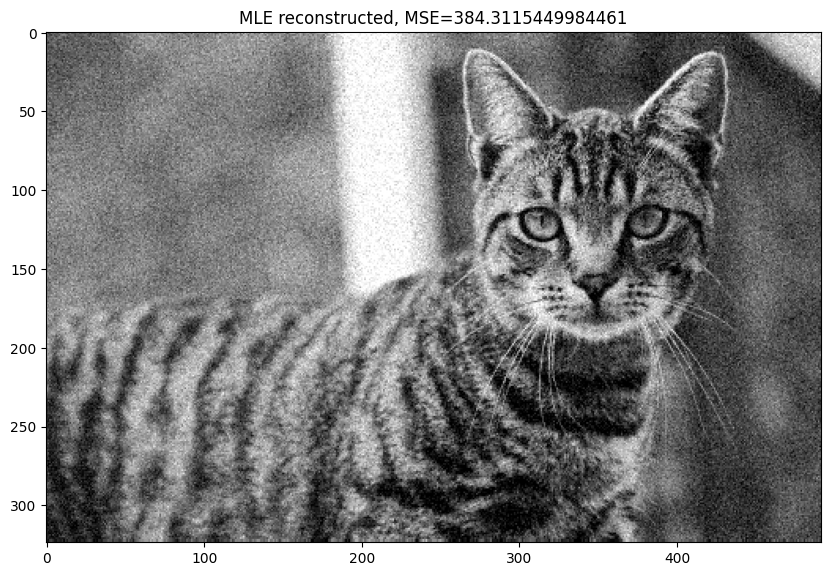

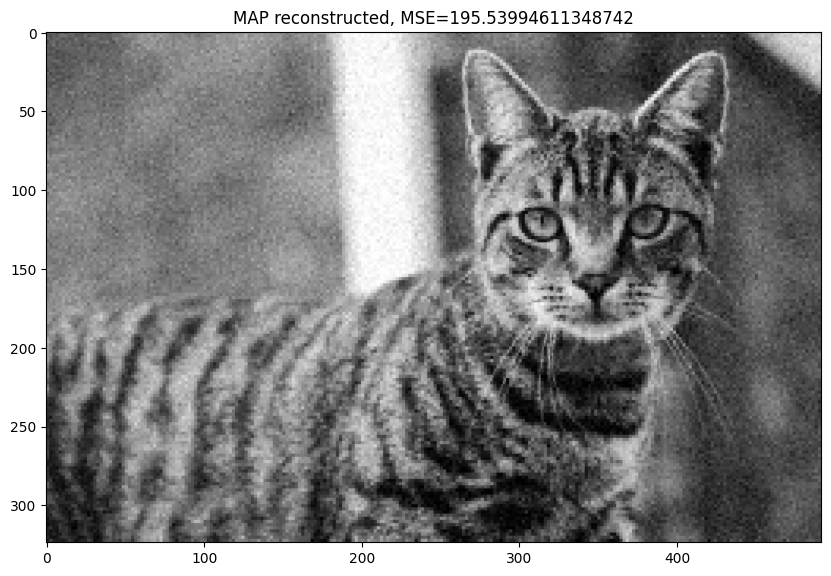

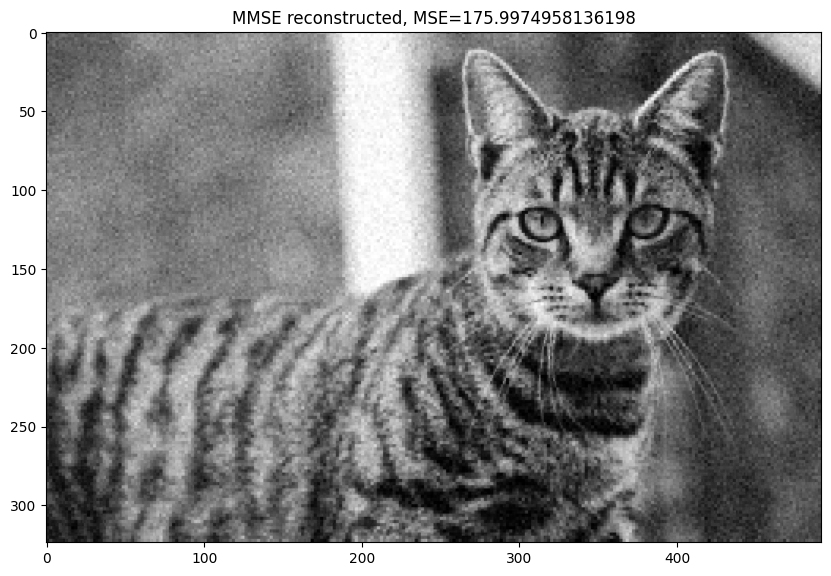

In [64]:
inv_mle = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
figure = plt.figure(figsize=(10,7))
plt.imshow(inv_mle, cmap=plt.cm.gray)
plt.title(f"MLE reconstructed, MSE={np.mean(np.square(inv_mle[:323,:]-original))}")
plt.show()

inv_map = pywt.idwt2((LL, (LH_map, HL_map, HH_map)), 'haar')
figure = plt.figure(figsize=(10,7))
plt.imshow(inv_map, cmap=plt.cm.gray)
plt.title(f"MAP reconstructed, MSE={np.mean(np.square(inv_map[:323,:]-original))}")
plt.show()

inv_mmse = pywt.idwt2((LL, (LH_mmse, HL_mmse, HH_mmse)), 'haar')
figure = plt.figure(figsize=(10,7))
plt.imshow(inv_mmse, cmap=plt.cm.gray)
plt.title(f"MMSE reconstructed, MSE={np.mean(np.square(inv_mmse[:323,:]-original))}")
plt.show()